# Table of contents
1. [Prepare input](#1)
2. [Implement Transformer](#2)
3. [Train and Evaluate](#3)
4. [Visualize attention](#4)

# Prepare essential packages

In [1]:
%matplotlib inline
!pip install --upgrade torchtext
!git clone https://github.com/sjpark9503/attentionviz.git
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 6.9MB 6.5MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
Cloning into 'attentionviz'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 10), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (30/30), done.
     |████████████████████████████████| 14.9MB 1.7MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=a6d26e159ed92002a60156197a3842e4ffeea233c7a97ab10ff8d8368dc7dd0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-y77ipg1w/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/

# I. Prepare input
<a id='1'></a>

We've already learned how to preprocess the text data in week 8, 9 & 10.

You can see some detailed explanation about translation datasets in [torchtext](https://pytorch.org/text/), [practice session,week 9](https://classum.com/main/course/7726/103) and [PyTorch NMT tutorial](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html)

In [2]:
import torch
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    shuffle=True)

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 751kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 229kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 218kB/s]
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# II. Implement Transformer
<a id='2'></a>
In practice week 11, we will learn how to implement the __[Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) (Vaswani et al., 2017)__

The overall architecutre is as follows:
![picture](http://incredible.ai/assets/images/transformer-architecture.png)

## 1. Basic building blocks

In this sections, we will implement the building blocks of the transformer: [Multi-head attention](#1a), [Position wise feedforward network](#1b) and [Positional encoding](#1c)

### a. Attention
<a id='1a'></a>
In this section, you will implement scaled dot-product attention and multi-head attention.

__Scaled dot product:__
![picture](http://incredible.ai/assets/images/transformer-scaled-dot-product.png)
__Multi-head attention:__
![picture](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$
__Query, Key and Value projection:__
![picture](http://jalammar.github.io/images/t/self-attention-matrix-calculation.png)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class MultiHeadAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        emb_dim,
        num_heads,
        dropout=0.0,
        bias=False,
        encoder_decoder_attention=False,  # otherwise self_attention
        causal = False
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads
        assert self.head_dim * num_heads == self.emb_dim, "emb_dim must be divisible by num_heads"

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_heads,
            self.head_dim,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
        # This is equivalent to
        # return x.transpose(1,2)
    
    def scaled_dot_product(self, 
                           query: torch.Tensor, 
                           key: torch.Tensor, 
                           value: torch.Tensor,
                           attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.emb_dim)
        
        if attention_mask is not None:
            attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1), float("-inf"))

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)

        return attn_output, attn_weights
    
    def MultiHead_scaled_dot_product(self, 
                       query: torch.Tensor, 
                       key: torch.Tensor, 
                       value: torch.Tensor,
                       attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.head_dim)
        
        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float("-inf"))
            else:
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float("-inf"))


        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.matmul(attn_probs, value)
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_attn_output_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_attn_output_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights

        
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        attention_mask: torch.Tensor = None,
        ):

        q = self.q_proj(query)
        # Enc-Dec attention
        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        # Self attention
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_output, attn_weights = self.MultiHead_scaled_dot_product(q,k,v,attention_mask)
        return attn_output, attn_weights


### b. Position-wise feed forward network
<a id='1b'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [4]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, emb_dim: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.activation = nn.ReLU()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout

    def forward(self, x):
        residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x + residual

### c. Sinusoidal Positional Encoding
<a id='1c'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [5]:
import numpy as np

class SinusoidalPositionalEmbedding(nn.Embedding):

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)
    
    @staticmethod
    def _init_weight(out: nn.Parameter):
        n_pos, embed_dim = out.shape
        pe = nn.Parameter(torch.zeros(out.shape))
        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                pe[pos, i] = np.sin(pos / (10000 ** ((2 * i) / embed_dim)))
                pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / embed_dim)))
        pe.detach_()
                
        return pe

    @torch.no_grad()
    def forward(self, input_ids):
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)

## 2. Transformer Encoder

Now we have all basic building blocks which are essential to build Transformer. 

Let's implement Transformer step-by-step

### a. Encoder layer
In this section, we will implement single layer of Transformer encoder.
![picture](https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm)

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(            
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads, 
            dropout=config.attention_dropout)
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.dropout = config.dropout
        self.activation_fn = nn.ReLU()
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)

    def forward(self, x, encoder_padding_mask):

        residual = x
        x, attn_weights = self.self_attn(query=x, key=x, attention_mask=encoder_padding_mask)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)
        if torch.isinf(x).any() or torch.isnan(x).any():
            clamp_value = torch.finfo(x.dtype).max - 1000
            x = torch.clamp(x, min=-clamp_value, max=clamp_value)
        return x, attn_weights

### b. Encoder

Stack encoder layers and build full Transformer encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()

        self.dropout = config.dropout

        emb_dim = embed_tokens.embedding_dim
        self.padding_idx = embed_tokens.padding_idx
        self.max_source_positions = config.max_position_embeddings

        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
                config.max_position_embeddings, config.emb_dim, self.padding_idx
            )

        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])

    def forward(self, input_ids, attention_mask=None):

        inputs_embeds = self.embed_tokens(input_ids)
        embed_pos = self.embed_positions(input_ids)
        x = inputs_embeds + embed_pos
        x = F.dropout(x, p=self.dropout, training=self.training)

        self_attn_scores = []
        for encoder_layer in self.layers:
            x, attn = encoder_layer(x, attention_mask)
            self_attn_scores.append(attn.detach())

        return x, self_attn_scores


## 3. Transformer Decoder

### a.Decoder layer
In this section, we will implement single layer of Transformer decoder.
![picture](http://incredible.ai/assets/images/transformer-decoder.png)

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            causal=True,
        )
        self.dropout = config.dropout
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.encoder_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            encoder_decoder_attention=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)


    def forward(
        self,
        x,
        encoder_hidden_states,
        encoder_attention_mask=None,
        causal_mask=None,
    ):
        residual = x
        # Self Attention
        x, self_attn_weights = self.self_attn(
            query=x,
            key=x, # adds keys to layer state
            attention_mask=causal_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)

        # Cross-Attention Block
        residual = x
        x, cross_attn_weights = self.encoder_attn(
            query=x,
            key=encoder_hidden_states,
            attention_mask=encoder_attention_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.encoder_attn_layer_norm(x)

        # Fully Connected
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)

        return (
            x,
            self_attn_weights,
            cross_attn_weights,
        ) 

### b. Decoder

Stack decoder layers and build full Transformer decoder.

Unlike the encoder, you need to do one more job: pass the causal(unidirectional) mask to the decoder self attention layer 

In [9]:
class Decoder(nn.Module):

    def __init__(self, config, embed_tokens: nn.Embedding):
        super().__init__()
        self.dropout = config.dropout
        self.padding_idx = embed_tokens.padding_idx
        self.max_target_positions = config.max_position_embeddings
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])  # type: List[DecoderLayer]

    def forward(
        self,
        input_ids,
        encoder_hidden_states,
        encoder_attention_mask,
        decoder_causal_mask,
    ):

        # embed positions
        positions = self.embed_positions(input_ids)
        x = self.embed_tokens(input_ids) 
        x += positions

        x = F.dropout(x, p=self.dropout, training=self.training)

        # decoder layers
        cross_attention_scores = []
        for idx, decoder_layer in enumerate(self.layers):
            x, layer_self_attn, layer_cross_attn = decoder_layer(
                x,
                encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                causal_mask=decoder_causal_mask,
            )
            cross_attention_scores.append(layer_cross_attn.detach())

        return x, cross_attention_scores

## 4. Transformer

Let's combine encoder and decoder in one place!

In [10]:
class Transformer(nn.Module):
    def __init__(self, SRC,TRG,config):
        super().__init__()
        
        self.SRC = SRC
        self.TRG = TRG
        
        self.enc_embedding = nn.Embedding(len(SRC.vocab), config.emb_dim, padding_idx=SRC.vocab.stoi['<pad>'])
        self.dec_embedding = nn.Embedding(len(TRG.vocab), config.emb_dim, padding_idx=TRG.vocab.stoi['<pad>'])

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        
        self.prediction_head = nn.Linear(config.emb_dim,len(TRG.vocab))
        
        self.init_weights()
        
    def generate_mask(self,src,trg):
        # Mask encoder attention to ignore padding
        enc_attention_mask = src.eq(SRC.vocab.stoi['<pad>']).to(device)
        # Mask decoder attention for causality
        tmp = torch.ones(trg.size(1), trg.size(1),dtype=torch.bool)
        mask = torch.arange(tmp.size(-1))
        dec_attention_mask = tmp.masked_fill_(mask < (mask + 1).view(tmp.size(-1), 1), False).to(device)
        
        return enc_attention_mask, dec_attention_mask
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weight' in name:
                    nn.init.normal_(param.data, mean=0, std=0.01)
                else:
                    nn.init.constant_(param.data, 0)
        
    def forward(
        self,
        src,
        trg,
    ):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, trg)
        encoder_output, encoder_attention_scores = self.encoder(
                input_ids=src,
                attention_mask=enc_attention_mask
            )

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        decoder_output, decoder_attention_scores = self.decoder(
            trg,
            encoder_output,
            encoder_attention_mask=enc_attention_mask,
            decoder_causal_mask=dec_causal_mask,
        )
        decoder_output = self.prediction_head(decoder_output)

        return decoder_output, encoder_attention_scores, decoder_attention_scores

# III. Train & Evaluate
<a id='3'></a>
This section is very similar to week 9, so please refer to it for detailed description.

## 1. Configuration

In [11]:
import easydict

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

config = easydict.EasyDict({
    "emb_dim":64,
    "ffn_dim":256,
    "attention_heads":4,
    "attention_dropout":0.0,
    "dropout":0.2,
    "max_position_embeddings":512,
    "encoder_layers":3,
    "decoder_layers":3,
    
})

N_EPOCHS = 100
learning_rate = 5e-4
CLIP = 1
PAD_IDX = TRG.vocab.stoi['<pad>']

model = Transformer(SRC,TRG,config)
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
            
best_valid_loss = float('inf')

## 2. Train & Eval

In [12]:
import math
import time
from tqdm import tqdm


def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    for idx, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, enc_attention_scores, _ = model(src, trg)

        output = output[:,:-1,:].reshape(-1, output.shape[-1])
        trg = trg[:,1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, attention_score, _ = model(src, trg) #turn off teacher forcing

            output = output[:,:-1,:].reshape(-1, output.shape[-1])
            trg = trg[:,1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

for epoch in tqdm(range(N_EPOCHS), total=N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    if best_valid_loss < valid_loss:
        break
    else:
        best_valid_loss = valid_loss

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
  1%|          | 1/100 [00:15<25:35, 15.51s/it]

	Train Loss: 7.459 | Train PPL: 1735.738
	 Val. Loss: 5.700 |  Val. PPL: 298.941


  2%|▏         | 2/100 [00:30<25:16, 15.47s/it]

	Train Loss: 5.392 | Train PPL: 219.665
	 Val. Loss: 5.161 |  Val. PPL: 174.401


  3%|▎         | 3/100 [00:46<24:54, 15.41s/it]

	Train Loss: 5.110 | Train PPL: 165.669
	 Val. Loss: 4.868 |  Val. PPL: 130.069


  4%|▍         | 4/100 [01:01<24:34, 15.36s/it]

	Train Loss: 4.783 | Train PPL: 119.423
	 Val. Loss: 4.519 |  Val. PPL:  91.747


  5%|▌         | 5/100 [01:16<24:15, 15.33s/it]

	Train Loss: 4.485 | Train PPL:  88.649
	 Val. Loss: 4.263 |  Val. PPL:  71.035


  6%|▌         | 6/100 [01:31<23:58, 15.31s/it]

	Train Loss: 4.277 | Train PPL:  72.010
	 Val. Loss: 4.083 |  Val. PPL:  59.336


  7%|▋         | 7/100 [01:47<23:41, 15.29s/it]

	Train Loss: 4.130 | Train PPL:  62.196
	 Val. Loss: 3.983 |  Val. PPL:  53.668


  8%|▊         | 8/100 [02:02<23:26, 15.29s/it]

	Train Loss: 4.026 | Train PPL:  56.013
	 Val. Loss: 3.887 |  Val. PPL:  48.763


  9%|▉         | 9/100 [02:17<23:10, 15.28s/it]

	Train Loss: 3.939 | Train PPL:  51.342
	 Val. Loss: 3.814 |  Val. PPL:  45.309


 10%|█         | 10/100 [02:32<22:53, 15.27s/it]

	Train Loss: 3.868 | Train PPL:  47.858
	 Val. Loss: 3.748 |  Val. PPL:  42.442


 11%|█         | 11/100 [02:48<22:40, 15.28s/it]

	Train Loss: 3.805 | Train PPL:  44.916
	 Val. Loss: 3.705 |  Val. PPL:  40.654


 12%|█▏        | 12/100 [03:03<22:27, 15.31s/it]

	Train Loss: 3.750 | Train PPL:  42.541
	 Val. Loss: 3.640 |  Val. PPL:  38.098


 13%|█▎        | 13/100 [03:19<22:16, 15.36s/it]

	Train Loss: 3.701 | Train PPL:  40.481
	 Val. Loss: 3.597 |  Val. PPL:  36.494


 14%|█▍        | 14/100 [03:34<22:05, 15.41s/it]

	Train Loss: 3.650 | Train PPL:  38.489
	 Val. Loss: 3.550 |  Val. PPL:  34.797


 15%|█▌        | 15/100 [03:50<21:52, 15.44s/it]

	Train Loss: 3.601 | Train PPL:  36.630
	 Val. Loss: 3.535 |  Val. PPL:  34.304


 16%|█▌        | 16/100 [04:05<21:39, 15.47s/it]

	Train Loss: 3.557 | Train PPL:  35.048
	 Val. Loss: 3.482 |  Val. PPL:  32.515


 17%|█▋        | 17/100 [04:21<21:25, 15.49s/it]

	Train Loss: 3.519 | Train PPL:  33.752
	 Val. Loss: 3.438 |  Val. PPL:  31.139


 18%|█▊        | 18/100 [04:36<21:11, 15.51s/it]

	Train Loss: 3.485 | Train PPL:  32.615
	 Val. Loss: 3.415 |  Val. PPL:  30.408


 19%|█▉        | 19/100 [04:52<20:56, 15.51s/it]

	Train Loss: 3.452 | Train PPL:  31.575
	 Val. Loss: 3.376 |  Val. PPL:  29.247


 20%|██        | 20/100 [05:07<20:40, 15.51s/it]

	Train Loss: 3.423 | Train PPL:  30.655
	 Val. Loss: 3.359 |  Val. PPL:  28.773


 21%|██        | 21/100 [05:23<20:25, 15.52s/it]

	Train Loss: 3.393 | Train PPL:  29.746
	 Val. Loss: 3.339 |  Val. PPL:  28.181
| Test Loss: 3.361 | Test PPL:  28.812 |


# IV. Visualization
<a id='4'></a>

## 1. Positional embedding visualization

Text(0, 0.5, 'Sequence Length')

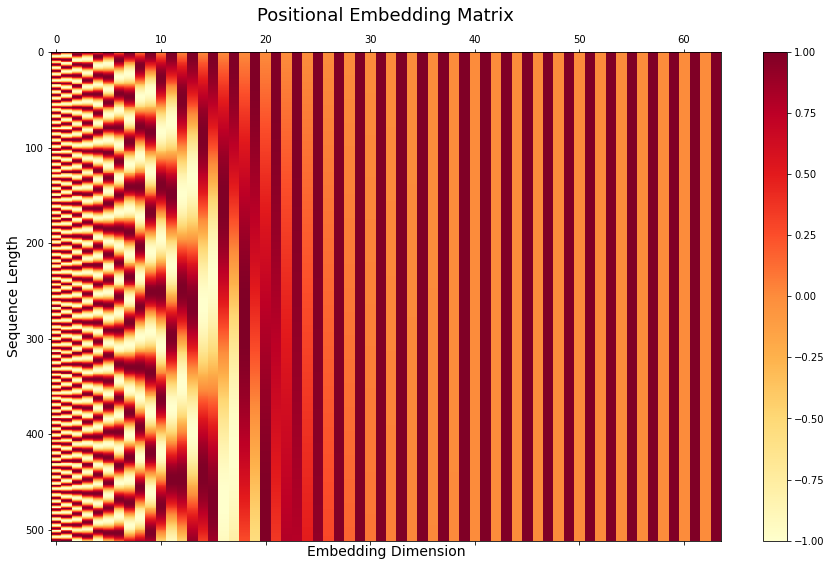

In [17]:
import matplotlib.pyplot as plt
# Visualization
fig, ax = plt.subplots(figsize=(15, 9))
cax = ax.matshow(model.encoder.embed_positions.weight.data.cpu().numpy(), aspect='auto',cmap=plt.cm.YlOrRd)
fig.colorbar(cax)
ax.set_title('Positional Embedding Matrix', fontsize=18)
ax.set_xlabel('Embedding Dimension', fontsize=14)
ax.set_ylabel('Sequence Length', fontsize=14)

## 2. Attention visualization

In [18]:
from attentionviz import head_view

BATCH_SIZE = 1
train_iterator, _, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

model.eval()

/usr/local/lib/python3.6/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Transformer(
  (enc_embedding): Embedding(7855, 64, padding_idx=1)
  (dec_embedding): Embedding(5893, 64, padding_idx=1)
  (encoder): Encoder(
    (embed_tokens): Embedding(7855, 64, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding(512, 64)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (k_proj): Linear(in_features=64, out_features=64, bias=False)
          (v_proj): Linear(in_features=64, out_features=64, bias=False)
          (q_proj): Linear(in_features=64, out_features=64, bias=False)
          (out_proj): Linear(in_features=64, out_features=64, bias=False)
        )
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (PositionWiseFeedForward): PositionWiseFeedForward(
          (activation): ReLU()
          (w_1): Linear(in_features=64, out_features=256, bias=True)
          (w_2): Linear(in_features=256, out_features=64, bias=True)
  

In [19]:
import sys
if not 'attentionviz' in sys.path:
  sys.path += ['attentionviz']
!pip install regex

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [20]:
SAMPLE_IDX = 131

with torch.no_grad():
  for idx,example in enumerate(test_iterator):
    if idx == SAMPLE_IDX:
      sample = example
  src = sample.src
  trg = sample.trg

  output, enc_attention_score, dec_attention_score = model(src, trg) #turn off teacher forcing
  attention_score = {'self':enc_attention_score, 'cross':dec_attention_score}

  src_tok = [SRC.vocab.itos[x] for x in src.squeeze()]
  trg_tok = [TRG.vocab.itos[x] for x in trg.squeeze()]

  call_html()
  head_view(attention_score, src_tok, trg_tok)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>